# Cox’s proportional hazard model
(https://lifelines.readthedocs.io/en/latest/Survival%20Regression.html)
The idea behind Cox’s proportional hazard model model is that the log-hazard of an individual is a linear function of their static covariates and a population-level baseline hazard that changes over time. 

We choose as the covariates the primary diagnosis and the cluster ID from our bioimage embedding


In [74]:
import pandas as pd
import numpy as np
import lifelines
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from lifelines import KaplanMeierFitter
from lifelines import CoxPHFitter

In [151]:
# figure out most common diagnoses
df_all_records = pd.read_csv("../data/histology_image_annotations.csv")
df_all_records = df_all_records.groupby("primary_diagnosis").agg(["size"])[["prefix"]]
df_all_records.columns = ["n_diagnoses"]
df_all_records = df_all_records.sort_values("n_diagnoses", ascending=False).reset_index()
df_all_records = df_all_records[df_all_records.primary_diagnosis != "Not Reported"]
relevant_diagnoses = set(df_all_records.head(10).primary_diagnosis)
diagnosis2id = {
    diagnosis: i for i, diagnosis in enumerate(relevant_diagnoses)
}
n_diagnoses = len(relevant_diagnoses)
set(relevant_diagnoses)

{'Adenocarcinoma, NOS',
 'Clear cell adenocarcinoma, NOS',
 'Glioblastoma',
 'Hepatocellular carcinoma, NOS',
 'Infiltrating duct carcinoma, NOS',
 'Malignant melanoma, NOS',
 'Papillary adenocarcinoma, NOS',
 'Serous cystadenocarcinoma, NOS',
 'Squamous cell carcinoma, NOS',
 'Transitional cell carcinoma'}

In [137]:
df = pd.read_csv("../data/dataset.csv")
df = df[df.primary_diagnosis.isin(relevant_diagnoses)]
df["diagnosis_id"] = df.primary_diagnosis.map(diagnosis2id)
df = df.drop(columns=["Unnamed: 0", "img_fp"])
df.primary_diagnosis.value_counts()

Adenocarcinoma, NOS               82
Clear cell adenocarcinoma, NOS    55
Papillary adenocarcinoma, NOS     53
Hepatocellular carcinoma, NOS     22
Malignant melanoma, NOS           19
Name: primary_diagnosis, dtype: int64

In [138]:
# create clusters
n_diagnoses = df.primary_diagnosis.nunique()
X = df[["l0", "l1", "l2", "l3"]]
cluster_id = KMeans(n_clusters=n_diagnoses, random_state=0).fit_predict(X)
cluster_id = [str(i) for i in cluster_id]
tsne = TSNE(n_components=2).fit_transform(X)
df = df.assign(
    cluster_id=cluster_id,
    tsne_1=tsne[:,0],
    tsne_2=tsne[:,1],
#     tsne_3=tsne[:,2],
)
df["Cluster ID"] = df.cluster_id.astype(np.uint8)
df.head()

,days_to_death,prefix,primary_diagnosis,diagnosis_year,time_since_diagnosis_aprox,problematic,l0,l1,l2,l3,diagnosis_id,cluster_id,tsne_1,tsne_2,Cluster ID
0,NaN,TCGA-CJ-4904,"Clear cell adenocarcinoma, NOS",2006.0,4745.0,False,0.872981,0.872878,0.872878,0.662831,7,1,-11.661077,0.850881,1
5,NaN,TCGA-G3-AAUZ,"Hepatocellular carcinoma, NOS",2013.0,2190.0,False,0.872878,0.872878,0.838404,0.000000,4,1,-16.070543,-1.437006,1
15,NaN,TCGA-HC-A48F,"Adenocarcinoma, NOS",2012.0,2555.0,False,0.872878,0.836921,0.872878,0.872944,2,1,-4.573316,1.349567,1
16,NaN,TCGA-X4-A8KQ,"Adenocarcinoma, NOS",2010.0,3285.0,False,0.873134,0.456335,0.856090,0.491725,2,4,-4.399453,-7.784282,4
17,NaN,TCGA-X4-A8KQ,"Adenocarcinoma, NOS",2010.0,3285.0,False,0.872878,0.878364,0.437443,0.849357,2,3,-7.415606,10.629781,3


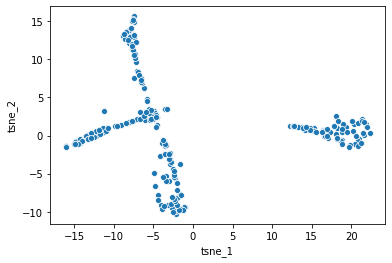

In [139]:
sns.scatterplot(data=df, x="tsne_1", y="tsne_2")

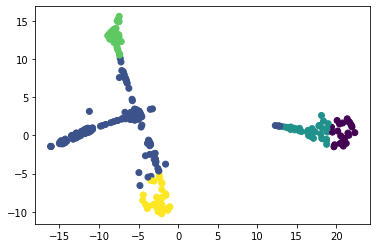

In [140]:
plt.scatter(x=df.tsne_1, y=df.tsne_2, c=df["Cluster ID"])

We have to determine which values to censure...

In [141]:
# "problematic" entries have neither a diagnosis date nor a death date
df.problematic.value_counts()

False    228
True       3
Name: problematic, dtype: int64

In [142]:
# they cannot be used unfortunately
df = df[~df.problematic]

In [143]:
# now, we create a single column representing the time value
df["T"] = df.days_to_death
df["observed"] = df.days_to_death.notna()
df.loc[df.days_to_death.isna(), "T"] = df.time_since_diagnosis_aprox

In [144]:
diagnoses = df.primary_diagnosis.unique()
diagnosis2code = {
    diagnosis: i for i, diagnosis in enumerate(diagnoses)
}
diagnosis2code

{'Clear cell adenocarcinoma, NOS': 0,
 'Hepatocellular carcinoma, NOS': 1,
 'Adenocarcinoma, NOS': 2,
 'Malignant melanoma, NOS': 3,
 'Papillary adenocarcinoma, NOS': 4}

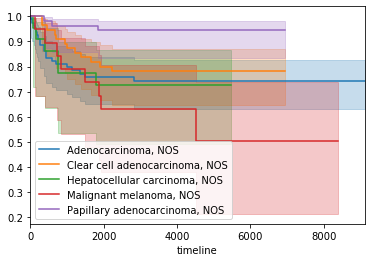

In [145]:
ax = plt.subplot(111)
kmf = KaplanMeierFitter()
for name, diagnosis_df in df.groupby("primary_diagnosis"):
    kmf.fit(diagnosis_df["T"], diagnosis_df["observed"], label=name)
    c = kmf.confidence_interval_survival_function_
    kmf.plot(ax=ax)

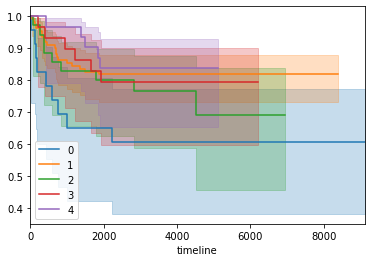

In [146]:
ax = plt.subplot(111)
kmf = KaplanMeierFitter()
for name, diagnosis_df in df.groupby("cluster_id"):
    kmf.fit(diagnosis_df["T"], diagnosis_df["observed"], label=name)
    c = kmf.confidence_interval_survival_function_
    kmf.plot(ax=ax)

In [147]:
_df = df[['T', 'observed', "diagnosis_id", 'cluster_id']]
cph = CoxPHFitter()
cph.fit(_df, 'T', 'observed')
cph.score_

0.5471997542745981

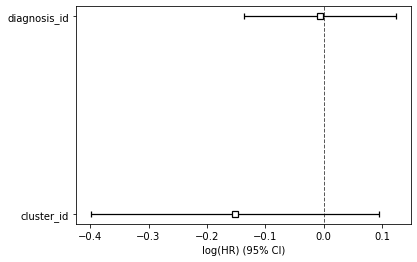

In [148]:
cph.plot()

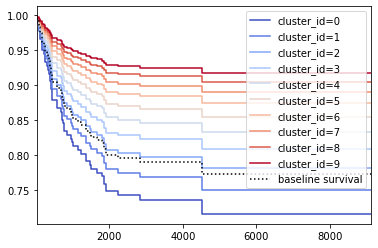

In [152]:
cph.plot_covariate_groups('cluster_id', list(range(n_diagnoses)), cmap='coolwarm')

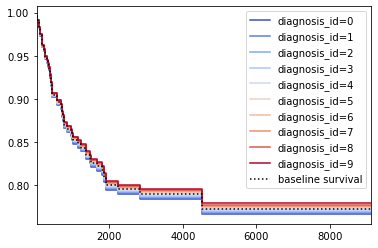

In [153]:
cph.plot_covariate_groups('diagnosis_id', list(range(n_diagnoses)), cmap='coolwarm')